In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.data import AUTOTUNE
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt

### Get our datasets as list of filepaths

In [2]:
cats = glob("../input/microsoft-catsvsdogs-dataset/PetImages/Cat/*.jpg")
dogs = glob("../input/microsoft-catsvsdogs-dataset/PetImages/Dog/*.jpg")
print(f"#cats: {len(cats)}, #dogs: {len(dogs)}")

#cats: 12500, #dogs: 12500


In [3]:
#create a fake dataset
labels = np.random.choice([0, 1], len(cats))
catset = tf.data.Dataset.from_tensor_slices(({'cats_input': cats}, labels))

2022-05-02 14:17:35.926104: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### Create functions just like you would for a single data instance (image in this case)

In [4]:
#preprocessing images
# @tf.function
def load_cat_image(inputs, labels):
    #inputs is a dictionary get the filename
    filename = inputs['cats_input'] 
    #read file 
    file = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(file)
    #make the image [0,1]
    image = tf.cast(image, tf.float32) / 255.0
    # reize image
    image = tf.image.resize(image, size = [64, 64])
    #note we are not returning the labels we do that later
    return image

In [5]:
#yield a batch from dataset
next(iter(catset))

({'cats_input': <tf.Tensor: shape=(), dtype=string, numpy=b'../input/microsoft-catsvsdogs-dataset/PetImages/Cat/7981.jpg'>},
 <tf.Tensor: shape=(), dtype=int64, numpy=0>)

In [6]:
#increase the batch size .batch(4)
catset = catset.batch(4)
#should return batch size number of datapoints
next(iter(catset))

({'cats_input': <tf.Tensor: shape=(4,), dtype=string, numpy=
  array([b'../input/microsoft-catsvsdogs-dataset/PetImages/Cat/7981.jpg',
         b'../input/microsoft-catsvsdogs-dataset/PetImages/Cat/6234.jpg',
         b'../input/microsoft-catsvsdogs-dataset/PetImages/Cat/1269.jpg',
         b'../input/microsoft-catsvsdogs-dataset/PetImages/Cat/3863.jpg'],
        dtype=object)>},
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 1, 1])>)

In [7]:
#reset
catset = tf.data.Dataset.from_tensor_slices(({'cats_input': cats}, labels))
#apply (map) function to every point in the dataset
catset = catset.map(load_cat_image)
next(iter(catset))

2022-05-02 14:17:36.452446: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


<tf.Tensor: shape=(64, 64, 3), dtype=float32, numpy=
array([[[0.05569278, 0.08173446, 0.11690602],
        [0.1354588 , 0.14250536, 0.18691215],
        [0.08329313, 0.10382008, 0.11999655],
        ...,
        [0.05212546, 0.07161076, 0.08717448],
        [0.09752029, 0.11712813, 0.1328144 ],
        [0.43264017, 0.4592333 , 0.47259116]],

       [[0.6165441 , 0.6428309 , 0.676147  ],
        [0.6292988 , 0.6363358 , 0.68059516],
        [0.6342525 , 0.65110296, 0.680576  ],
        ...,
        [0.15190335, 0.17138864, 0.18695235],
        [0.06542586, 0.08503371, 0.10071998],
        [0.26944318, 0.3026712 , 0.3132717 ]],

       [[0.62591535, 0.6406212 , 0.6923082 ],
        [0.60903996, 0.6194566 , 0.6878505 ],
        [0.6013883 , 0.6203221 , 0.64587355],
        ...,
        [0.35133082, 0.3675475 , 0.38041323],
        [0.14945045, 0.16256319, 0.18149701],
        [0.13001494, 0.14097925, 0.16058709]],

       ...,

       [[0.8818302 , 0.86136454, 0.8236768 ],
        [0.8720

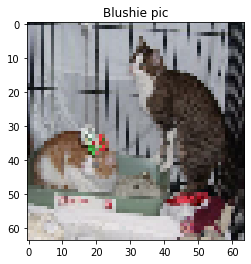

In [8]:
image = next(iter(catset)).numpy()
plt.imshow(image)
plt.title("Blushie pic")
plt.show()

shape of batch: (2, 64, 64, 3) 



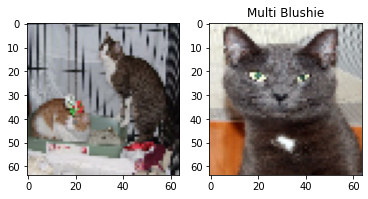

In [9]:
#reset
catset = tf.data.Dataset.from_tensor_slices(({'cats_input': cats}, labels))
#apply (map) function to every point in the dataset then tell the batch size
catset = catset.map(load_cat_image).batch(2)
images = next(iter(catset)).numpy()
print(f"shape of batch: {images.shape} \n")
fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[0])
ax[1].imshow(images[1])
plt.title("Multi Blushie")
plt.show()

### ok we got that down!
lets try with creating a dataset that yields an image of a cat and a dog!

In [10]:
#this decorate makes stuff faster: https://www.tensorflow.org/guide/function
# @tf.function
def load_images(inputs, labels):
    filename = inputs['cats_input']
    cat = tf.io.read_file(filename)
    cat = tf.image.decode_jpeg(cat)
    cat = tf.cast(cat, tf.float32) / 255.0
    cat = tf.image.resize(cat, size = [64, 64])

    dog_filename = inputs['dogs_input']
    dog = tf.io.read_file(dog_filename)
    dog = tf.image.decode_jpeg(dog)
    dog = tf.cast(dog, tf.float32) / 255.0
    dog = tf.image.resize(dog, size = [64, 64])
    # now we also return the labels since I want to show you how to use it
    return {'cats_input': cat, 'dogs_input': dog}, labels

In [11]:
dataset = tf.data.Dataset.from_tensor_slices(({'cats_input': cats, 'dogs_input': dogs}, labels))

In [12]:
print(f"one cat and one dog + label coming up:")
(cat, dog), label = next(iter(dataset))
print(f"a dog {dog} and a cat {cat} walk into a bar and see a label {label}")

one cat and one dog + label coming up:
a dog dogs_input and a cat cats_input walk into a bar and see a label 0


### we are experts now, skip above steps and return a batch of 2 = 4 images

shape of batch: (2, 64, 64, 3) 

shape of batch: (2, 64, 64, 3) 

shape of batch: (2,) 



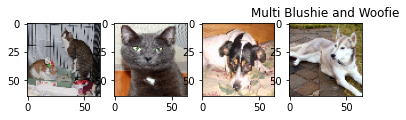

In [13]:
dataset = dataset.map(load_images).batch(2)
images, catdog_labels = next(iter(dataset)) #this is a dict now:

print(f"shape of batch: {images['cats_input'].shape} \n")
print(f"shape of batch: {images['dogs_input'].shape} \n")
print(f"shape of batch: {catdog_labels.shape} \n")
fig, ax = plt.subplots(1, 4)
ax[0].imshow(images['cats_input'][0].numpy())
ax[1].imshow(images['cats_input'][1].numpy())
ax[2].imshow(images['dogs_input'][0].numpy())
ax[3].imshow(images['dogs_input'][1].numpy())
plt.title("Multi Blushie and Woofie")
plt.show()

In [14]:
shape = images['cats_input'][0].numpy().shape

# How to use in Keras

In [15]:
catinput = Input(shape, name = "cats_input")
doginput = Input(shape, name = "dogs_input")
cat1 = Conv2D(filters = 1, kernel_size = 2, strides = 1)(catinput)
dog1 = Conv2D(filters = 1, kernel_size = 2, strides = 1)(doginput)
out = concatenate([cat1, dog1])
out = Flatten()(out)
out = Dense(1, activation = 'sigmoid')(out)
model = Model(inputs = [catinput, doginput], outputs = out, name = "Convolution_Model")
model.summary()

Model: "Convolution_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cats_input (InputLayer)         [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
dogs_input (InputLayer)         [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 1)    13          cats_input[0][0]                 
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 63, 63, 1)    13          dogs_input[0][0]                 
__________________________________________________________________________________

In [16]:
model.compile(loss='categorical_crossentropy',optimizer= 'sgd',metrics=['categorical_accuracy'])

In [17]:
#this decorate makes stuff faster: https://www.tensorflow.org/guide/function
@tf.function
def load_images(inputs, labels):
    filename = inputs['cats_input']
    cat = tf.io.read_file(filename)
    cat = tf.image.decode_jpeg(cat)
    cat = tf.cast(cat, tf.float32) / 255.0
    cat = tf.image.resize(cat, size = [64, 64])

    dog_filename = inputs['dogs_input']
    dog = tf.io.read_file(dog_filename)
    dog = tf.image.decode_jpeg(dog)
    dog = tf.cast(dog, tf.float32) / 255.0
    dog = tf.image.resize(dog, size = [64, 64])
    # now we also return the labels since I want to show you how to use it
    return {'cats_input': cat, 'dogs_input': dog}, labels

In [18]:
#there is a broken image in the dataset so I just use the first 32 to not deal with that
#sorry picked a bad dataset for the example and realized too late
cats = glob("../input/microsoft-catsvsdogs-dataset/PetImages/Cat/*.jpg")[:32]
dogs = glob("../input/microsoft-catsvsdogs-dataset/PetImages/Dog/*.jpg")[:32]
print(f"#cats: {len(cats)}, #dogs: {len(dogs)}")
dataset = tf.data.Dataset.from_tensor_slices(({'cats_input': cats, 'dogs_input': dogs}, labels[:32]))
dataset = dataset.map(load_images, num_parallel_calls = AUTOTUNE).cache().batch(32).prefetch(AUTOTUNE)

#cats: 32, #dogs: 32


In [19]:
model.fit(dataset)

1/1 [==============================] - 1s 696ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000


### read the guide on how to use prefetch, cache, shuffle map and in which order